<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave-Sentence-Embedding-Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import pandas as pd
import numpy as np
import spacy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score


SyntaxError: ignored

In [153]:
!pip uninstall umap
!pip install umap-learn -i https://mirrors.ustc.edu.cn/pypi/web/simple

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('drive/Shareddrives/Milestone 2/Training_set.csv', 
                      sep='\t',index_col='ix')
# train['lemmatized_text'] = train['lemmatized_text'].fillna('')
train['lemmatized_text'] = train['lemmatized_text'].astype(str)

In [4]:
sample_df = train.groupby('label').apply(lambda x: x.sample(2500, random_state=99))

In [5]:
sample_df.label.value_counts()

0    2500
1    2500
Name: label, dtype: int64

In [6]:
nlp = spacy.load("en_core_web_sm")

In [7]:
sample_df['embedding'] =  (sample_df['lemmatized_text']
                           .apply(lambda doc: nlp(doc).vector))

X = pd.DataFrame([x for x in sample_df['embedding']])

In [30]:
def find_best_kmeans(X,n_clus_lst, params):
  m = {'cluster':[],
            'score':[],
             'best_model':None}
  for idx, n in enumerate(n_clus_lst):
    km = KMeans(n_clusters=n,
                random_state=99)
    km.fit(X)
    score = silhouette_score(X,km.labels_,
                    random_state=99)
    m['cluster'].append(n)
    m['score'].append(score)
    if m['best_model'] is None:
      m['best_model'] = km
    elif score > np.max(m['score']):
      m['best_model'] = km
  return m


def plot_clusters(feature_one, feature_two, labels,title):
  plt.figure(figsize=(10,10))
  plt.title(title)
  plt.xlabel("feature 1")
  plt.ylabel("feature 2")
  sns.scatterplot(x=feature_one,
                  y=feature_two,
                  hue=labels,
                  alpha=.3,
                  );

In [24]:
# np.unique(results['best_model'].n_clusters_)


2

In [9]:
X_std = MinMaxScaler().fit_transform(X)

In [43]:
X_pca = PCA(n_components=5).fit_transform(X_std)

In [11]:
import seaborn as sns

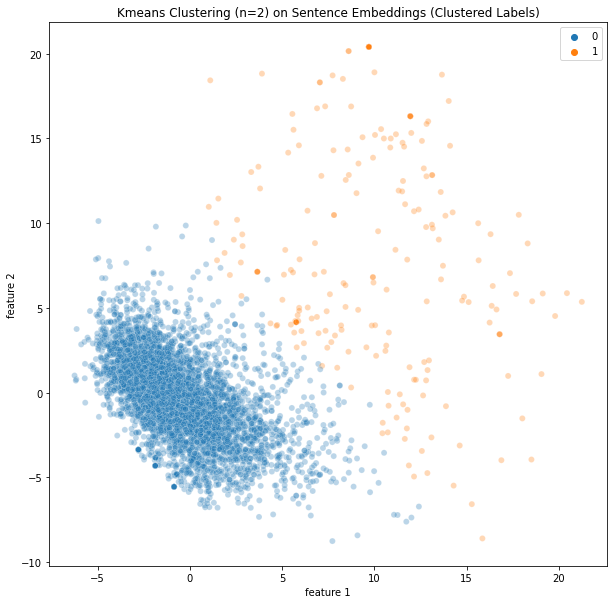

In [31]:
results = find_best_kmeans(X_pca, [x for x in range(2,10)])
km = results['best_model']
feat_one = X_pca[:,0]
feat_two = X_pca[:,1]
title = f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Clustered Labels)"
plot_clusters(feat_one,
              feat_two,
              km.labels_, title)


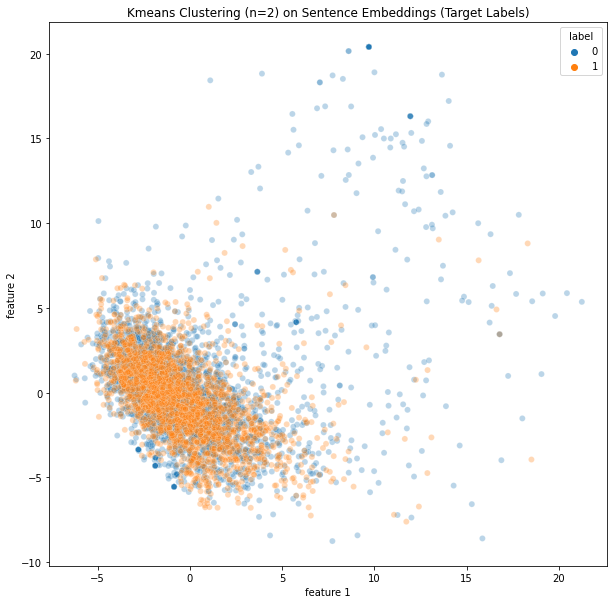

In [69]:
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Sentence Embeddings (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")

g =sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3,
                legend='full');

In [71]:
sample_df['emb_member'] = km.labels_

In [80]:
sample_df = sample_df.reset_index(level=0, drop=True)

In [84]:
sample_df['emb_member'].value_counts()

0    4784
1     216
Name: emb_member, dtype: int64

# Clustering on Tfidf Vectorized Text

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [86]:
vec = TfidfVectorizer( min_df=20,
                      ngram_range=(1,3)
                      )
X_vec = vec.fit_transform(sample_df['lemmatized_text'])

In [94]:
n_clust_lst = [x for x in range(2,11)]
tf_results = find_best_kmeans(X,n_clust_lst)

In [95]:
tf_results

{'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
 'score': [0.5381558,
  0.10730185,
  0.05862055,
  0.05693231,
  0.04158612,
  0.036072604,
  0.038388208,
  0.030619448,
  0.039599318],
 'best_model': KMeans(n_clusters=2, random_state=99)}

In [96]:
X_pca = PCA().fit_transform(X_vec.todense())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


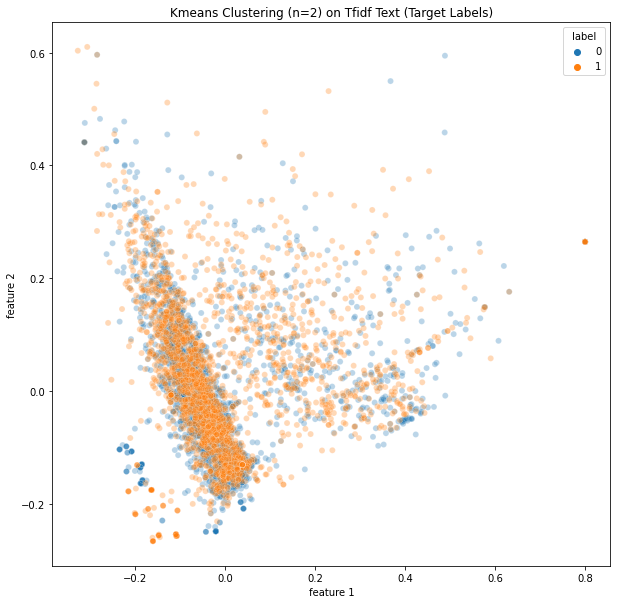

In [99]:
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Tfidf Text (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
sns.scatterplot(x=X_pca[:,0],
                y=X_pca[:,1],
                hue=sample_df.label,
                alpha=.3);

# Numeric Features

In [100]:
num_features = ['d_chall_score', 'aoa_mean',
       'aoa_min', 'aoa_max', 'conc_rating_mean', 'conc_rating_min',
       'conc_rating_max', 'num_lemmas']

In [101]:
si = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = si.fit_transform(sample_df[num_features])
X_num_std = StandardScaler().fit_transform(X_num)


In [102]:
metrics = find_best_kmeans(X_num_std,[2,3,4,5,6,7,8])

In [103]:
metrics

{'cluster': [2, 3, 4, 5, 6, 7, 8],
 'score': [0.578215750326415,
  0.5827496800305163,
  0.1915945984651341,
  0.22061948770636472,
  0.2286004387003079,
  0.20774957793808052,
  0.19839061540106112],
 'best_model': KMeans(n_clusters=2, random_state=99)}

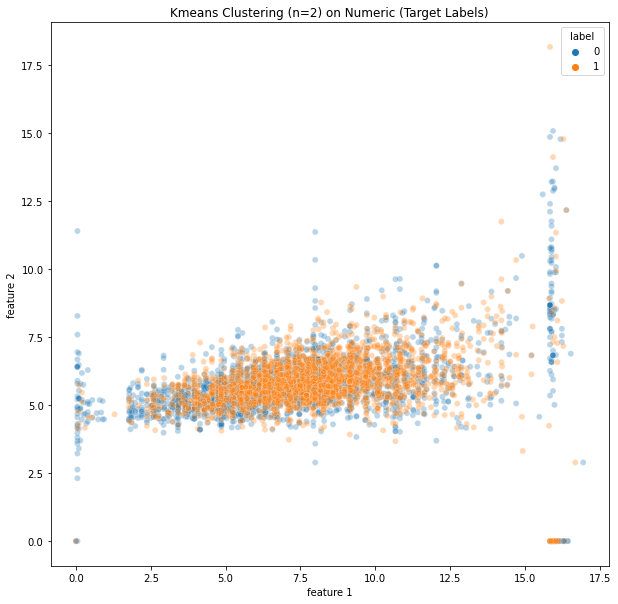

In [116]:
c_labels = metrics['best_model'].labels_
plt.figure(figsize=(10,10))
plt.title(f"Kmeans Clustering (n={km.n_clusters}) on Numeric (Target Labels)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
sns.scatterplot(x=sample_df['d_chall_score'],
                y=sample_df['aoa_mean'],
                hue=sample_df.label,
                alpha=.3);


(5000, 8)

# Using UMAP For Dimensionality-Reduction

In [155]:
import umap

In [191]:
# Code obtained and slightly modified from https://umap-learn.readthedocs.io/en/latest/parameters.html

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    data=X_std
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)),c=data[:,0])
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data[:,0])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2])
    plt.title(title, fontsize=18)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/spectral.py:261: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
/usr/local/lib/python3.7/dist-packages/umap/s

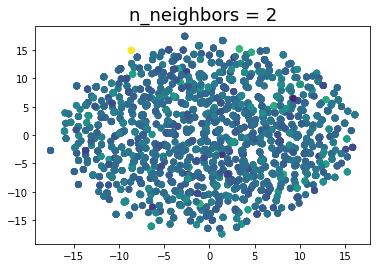

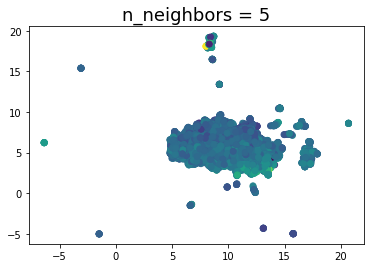

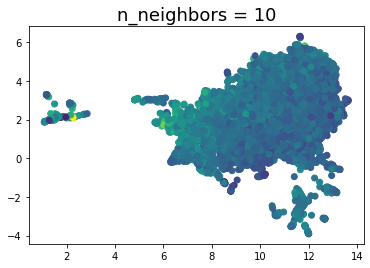

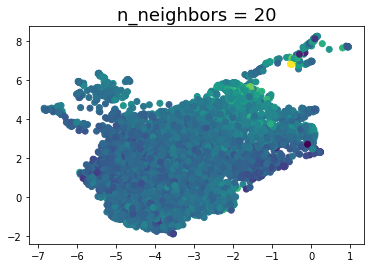

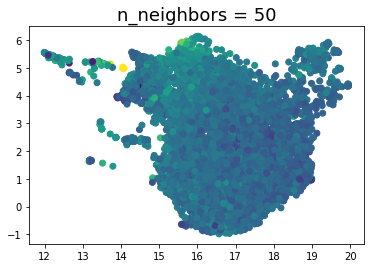

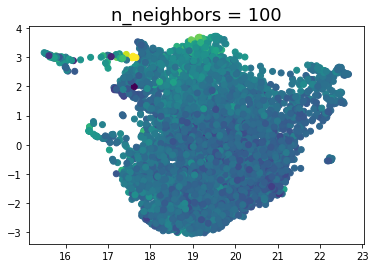

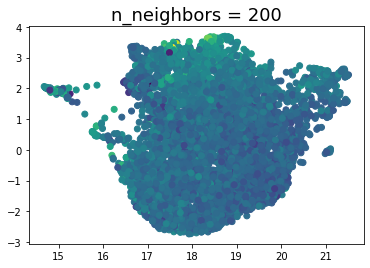

In [192]:
# reducer = umap.UMAP(n_neighbors=5, n_components=2)
# embs = reducer.fit_transform(X_std)

for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [185]:
data.shape

(5000, 96)